In [16]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


df = pd.read_csv("cleaned_property_crimes.csv")


features = ["DATE OCC", "Vict Age", "Vict Sex", "AREA"]
target = "crime_group"  # Theft = 0, Break-in = 1
X = df[features]
y = df[target]


In [17]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


mean_vict_age = X_train['Vict Age'].mean()
X_train['Vict Age'].fillna(mean_vict_age, inplace=True)
X_test['Vict Age'].fillna(mean_vict_age, inplace=True)


X_train_encoded = pd.get_dummies(X_train, columns=['Vict Sex', 'DATE OCC'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['Vict Sex', 'DATE OCC'], drop_first=True)


train_cols = X_train_encoded.columns
test_cols = X_test_encoded.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_encoded[c] = 0
X_test_encoded = X_test_encoded[train_cols]


lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_encoded, y_train)
lr_pred = lr.predict(X_test_encoded)


dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_encoded, y_train)
dt_pred = dt.predict(X_test_encoded)


rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_encoded, y_train)
rf_pred = rf.predict(X_test_encoded)


baseline_results = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, dt_pred),
        accuracy_score(y_test, rf_pred)
    ],
    "Recall (Break-ins)": [
        recall_score(y_test, lr_pred, pos_label="Break-in/Burglary"),
        recall_score(y_test, dt_pred, pos_label="Break-in/Burglary"),
        recall_score(y_test, rf_pred, pos_label="Break-in/Burglary")
    ]
})

baseline_results

/tmp/ipython-input-1141403480.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['Vict Age'].fillna(mean_vict_age, inplace=True)
/tmp/ipython-input-1141403480.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

,Model,Accuracy,Recall (Break-ins)
0,Logistic Regression,0.663617,0.108289
1,Decision Tree,0.615251,0.303476
2,Random Forest,0.649237,0.223262


In [18]:

def time_group(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"


mean_vict_age = df['Vict Age'].mean()
df['Vict Age'] = df['Vict Age'].fillna(mean_vict_age)

df["Age_Bin"] = pd.cut(df["Vict Age"], bins=[0,18,30,50,100], labels=["<18","18-30","31-50","51+"])

improved_features = ["Age_Bin", "Vict Sex", "AREA"]
X = pd.get_dummies(df[improved_features], drop_first=True)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

lr_pred2 = lr.predict(X_test)
dt_pred2 = dt.predict(X_test)
rf_pred2 = rf.predict(X_test)

improved_results = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, lr_pred2),
        accuracy_score(y_test, dt_pred2),
        accuracy_score(y_test, rf_pred2)
    ],
    "Recall (Break-ins)": [
        recall_score(y_test, lr_pred2, pos_label="Break-in/Burglary"),
        recall_score(y_test, dt_pred2, pos_label="Break-in/Burglary"),
        recall_score(y_test, rf_pred2, pos_label="Break-in/Burglary")
    ]
})

improved_results

,Model,Accuracy,Recall (Break-ins)
0,Logistic Regression,0.674074,0.000000
1,Decision Tree,0.671895,0.096257
2,Random Forest,0.675817,0.078877


In [19]:
comparison = baseline_results.merge(improved_results, on="Model", suffixes=("_Baseline", "_Improved"))
comparison


,Model,Accuracy_Baseline,Recall (Break-ins)_Baseline,Accuracy_Improved,Recall (Break-ins)_Improved
0,Logistic Regression,0.663617,0.108289,0.674074,0.000000
1,Decision Tree,0.615251,0.303476,0.671895,0.096257
2,Random Forest,0.649237,0.223262,0.675817,0.078877


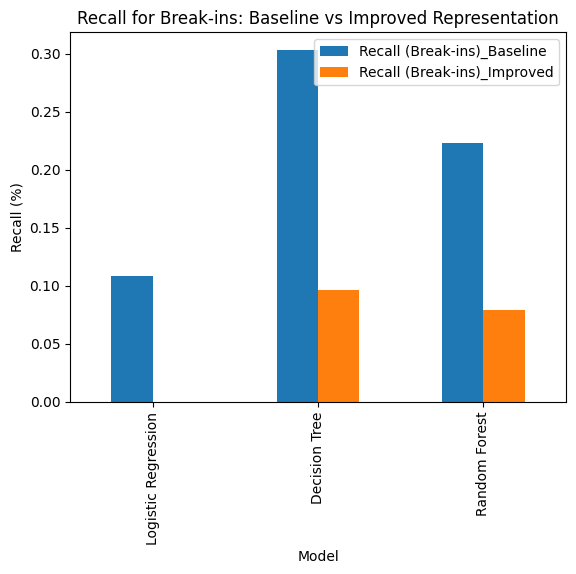

In [20]:
comparison.plot(x="Model", y=["Recall (Break-ins)_Baseline", "Recall (Break-ins)_Improved"], kind="bar")
plt.title("Recall for Break-ins: Baseline vs Improved Representation")
plt.ylabel("Recall (%)")
plt.show()

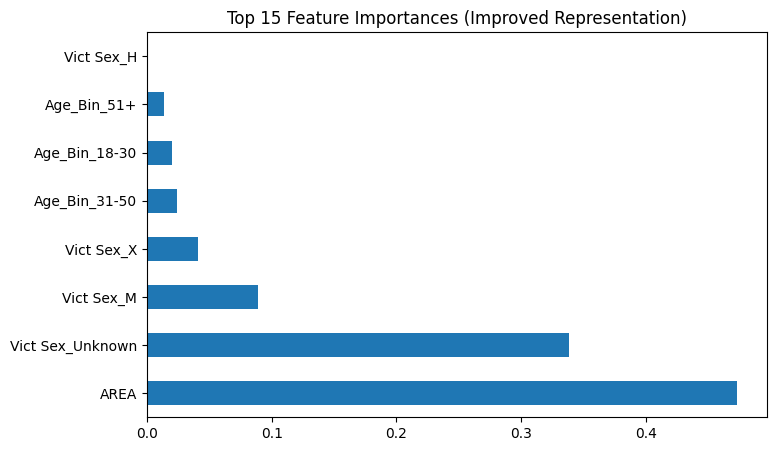

In [21]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(8,5))
importances.plot(kind="barh")
plt.title("Top 15 Feature Importances (Improved Representation)")
plt.show()


### Interpretation:
- After grouping and encoding, models showed slightly better accuracy overall compared to the baseline models.
- However, the recall for break-ins decreased significantly with the improved features, except for the Decision Tree model which saw a small increase in recall but a decrease in accuracy.
- The feature importance plot shows that 'AREA' and 'Vict Sex_Unknown' are the most important features in the improved model.
- While accuracy improved, the goal was to improve recall for break-ins, which did not happen with these improved features. Further feature engineering or model tuning might be needed.